In [1]:
TEST = '/kaggle/input/rice-leaf-disease-riceguard-19k-cleaned/test'
TRAIN = '/kaggle/input/rice-leaf-disease-riceguard-19k-cleaned/train'
VAL = '/kaggle/input/rice-leaf-disease-riceguard-19k-cleaned/val'

We want to use image embeddings for both EDA and classification, so let's add some code to get image embeddings using ResNeXt without fine-tuning.

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth


100%|██████████| 95.8M/95.8M [00:00<00:00, 178MB/s]


Let's load up our data, starting with a small sample.

In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from os.path import isdir
from PIL import Image

THUMBNAIL_SIZE = (48, 48)

def embed(model, filename: str):
    try:
        with Image.open(fp=filename, mode='r') as image:
            return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)
    except: 
        print(filename)
        return None


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'])
        for index, input_file in enumerate(list(iglob(pathname=arg))) if index < 100]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*') if isdir(folder)}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
test_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TEST + '/*') if isdir(folder)}
test_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in test_dict.items()]))
val_dict = {basename(folder) : folder + '/*.*' for folder in iglob(VAL + '/*') if isdir(folder)}
val_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in val_dict.items()]))
train_df = pd.concat(axis='index', objs=[train_df, val_df])
print('done in {}'.format(arrow.now() - time_start))

encoded 100 rows of tungro  in 0:00:23.040334
encoded 100 rows of stripes  in 0:00:21.789068
encoded 100 rows of insect  in 0:00:22.307029
encoded 100 rows of leaf_folder  in 0:00:24.723856
encoded 100 rows of blast  in 0:00:22.454196
encoded 100 rows of healthy  in 0:00:23.757546
encoded 100 rows of scald  in 0:00:24.206083
encoded 100 rows of tungro  in 0:00:23.152147
encoded 100 rows of stripes  in 0:00:23.040845
encoded 100 rows of insect  in 0:00:20.397037
encoded 100 rows of leaf_folder  in 0:00:26.403803
encoded 100 rows of blast  in 0:00:22.211511
encoded 100 rows of healthy  in 0:00:22.197559
encoded 64 rows of scald  in 0:00:15.280179
encoded 100 rows of tungro  in 0:00:23.535578
encoded 100 rows of stripes  in 0:00:23.789311
encoded 100 rows of insect  in 0:00:21.770348
encoded 100 rows of leaf_folder  in 0:00:25.362967
encoded 100 rows of blast  in 0:00:23.457152
encoded 100 rows of healthy  in 0:00:23.390108
encoded 63 rows of scald  in 0:00:15.398383
done in 0:07:51.83454

Even with a small sample our classes are not balanced in our training data; apparently scald is hard to find.

In [4]:
train_df['tag'].value_counts(normalize=True).to_frame().T

tag           tungro   stripes    insect  leaf_folder     blast   healthy  \
proportion  0.146735  0.146735  0.146735     0.146735  0.146735  0.146735   

tag            scald  
proportion  0.119589

Our least-well-represented class is pretty well represented; let's proceeed by using TSNE to add x/y coordinates based on our image embeddings, so we can make an interactive exploratory plot.

In [5]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))
test_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
test_df[['x', 'y']] = test_reducer.fit_transform(X=test_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1363 samples in 0.010s...
[t-SNE] Computed neighbors for 1363 samples in 0.273s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1363
[t-SNE] Computed conditional probabilities for sample 1363 / 1363
[t-SNE] Mean sigma: 3.781354
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.649963
[t-SNE] KL divergence after 1000 iterations: 1.566344
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 664 samples in 0.003s...
[t-SNE] Computed neighbors for 664 samples in 0.081s...
[t-SNE] Computed conditional probabilities for sample 664 / 664
[t-SNE] Mean sigma: 4.281046
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.977783
[t-SNE] KL divergence after 1000 iterations: 1.159624


Let's plot.

In [6]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']].sample(n=min(len(train_df) - 1, 10000)))
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: rice leaf diseases', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? A mess. We do see some local clustering in some classes, but we see a lot of mixing. Let's build a model and see what we get.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

logreg = LogisticRegression(max_iter=1000, tol=1e-12).fit(train_df['value'].apply(func=pd.Series), train_df['tag'])
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series)))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series)))))
print(classification_report(zero_division=0.0, y_true=test_df['tag'], y_pred=logreg.predict(X=test_df['value'].apply(func=pd.Series))))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model fit in 1000 iterations
accuracy: 0.6747
f1: 0.6727
              precision    recall  f1-score   support

       blast       0.61      0.61      0.61       100
     healthy       0.67      0.68      0.68       100
      insect       0.76      0.78      0.77       100
 leaf_folder       0.65      0.63      0.64       100
       scald       0.63      0.67      0.65        64
     stripes       0.71      0.55      0.62       100
      tungro       0.68      0.80      0.74       100

    accuracy                           0.67       664
   macro avg       0.67      0.67      0.67       664
weighted avg       0.68      0.67      0.67       664



Our model doesn't do a great job of capturing any of our classes, but it performs about the same across the classes. Let's take a look at our model probabilities.

<Axes: xlabel='probability', ylabel='Count'>

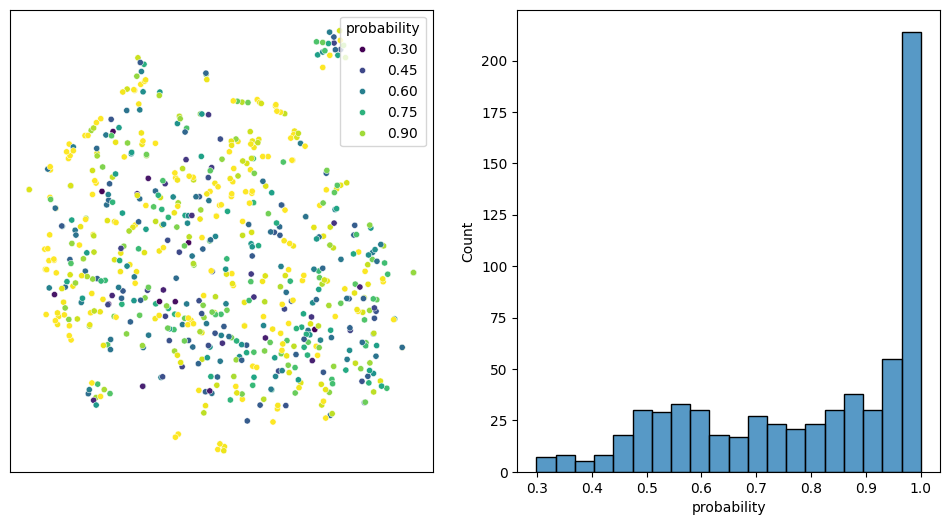

In [8]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = test_df[['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=test_df['value'].apply(func=pd.Series)), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis', s=20)
ax[0].set(xlabel=None)
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

This is a tough problem, and we have a lot of low-probability classifications. Let's make a second plot of just our test data.

In [9]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(test_df[['png', 'tag', 'x', 'y']].sample(n=min(len(test_df) - 1, 10000)))

plot_figure = figure(title='TSNE projection: rice leaf diseases (test data)', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

We see some local clustering in our test data as well. This is just a hard problem.